
# Background

Hello! My name is Pankaj, and like my other 1.33 Billion Indians, I too am fond of our Indian traditional cuisine, and am proud of it!

The one thing we all Indians love unanimously is our Indian food! We are closely connected to the aroma & taste of the variety of spices, which bring the unique taste to our food.

Back in 2009, I planned to travel to New York along with group of Indian friends. Well, we made all necessary arrangements but the most important topic with a big question mark was - where do we find Indian restaurants?

New York is known for its long history of immigration & ethnically diverse culture & food. But none of us had luxury of carrying smartphones, which could give us feedback on Indian restaurants within New York back then.

We managed to do a bit of research about good Indian food in NY by Internet searches, asking hotel staff, little bit of strolling around and found couple of Indian takeaway/Dine-in restaurants around but the lack of taste was pointing to only result - our research wasn't good.

Today, as a part of my Capstone Data Science project, I'll like to utilize my Data Science skills to solve a few basic problems of finding out

* Which areas in NY have Indian restaurants?
* Which is the best location to look for Indian restaurants in NY?
* Where should I stay to have multiple options of Indian restaurants around?



# Data description

For this project we would be looking at below data

(1) New York City data that contains list Boroughs, Neighbourhoods along with their latitude and longitude.
    * Data source : https://cocl.us/new_york_dataset 
    * Description : This data set contains the required information. And we will use this data set to explore various neighbourhoods of New York City.
    
(2) Indian restaurants in each neighbourhood of New York City.
    * Data source : Fousquare API 
    * Description : By using this API, we will get all the venues in each neighbourhood. We can filter these venues to get only Indian restaurants.

(3) GeoSpace data 
    * Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm 
    * Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.


# Problem solving approach

*  Collect the New York City data from https://cocl.us/new_york_dataset
*  Using FourSquare API we will find all venues for each neighbourhood.
*  Filter out all venues that are Indian Restaurants.
*  Find rating, tips and like count for each Indian Restaurants using FourSquare API.
*  Using rating for each restaurant, we will sort that data.


In [1]:
import pandas as pd


In [2]:
! pip install geocoder

In [3]:
# pandas and numpy will be used for handling data.
#request module will be used for using FourSquare API.
#geopy will be used to get co-ordinates of City of New York.

import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import sys
from bs4 import BeautifulSoup
import os
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print('Libraries successfully imported.')


Libraries successfully imported.


In [4]:
! pip install folium
import folium
# folium will be needed to visualize the results on a map
print('folium library successfully imported.')


folium library successfully imported.


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [5]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.


In [6]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'TIPJ31HVVDSQVZWMTETJUSYPYN12L0U1RXO0I1PRRJHCGH3U'
    CLIENT_SECRET = 'RYYSTRNCWYDSKTFVJHPQDQTDTZDDTZSG2FJ5IH2500UHFHYW' 
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [7]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'TIPJ31HVVDSQVZWMTETJUSYPYN12L0U1RXO0I1PRRJHCGH3U' 
    CLIENT_SECRET = 'RYYSTRNCWYDSKTFVJHPQDQTDTZDDTZSG2FJ5IH2500UHFHYW' 
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [8]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.


In [9]:
# get new york data
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [10]:
new_york_data.shape


(306, 4)

So there are total of 306 different Neighbourhoods in New York



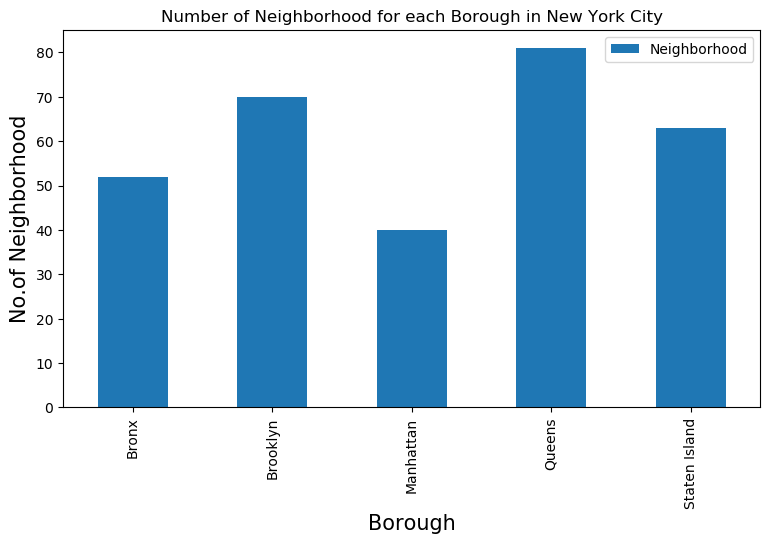

In [11]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has highest number of neighborhoods

Now we will collect Indian resturants for each Neighborhood

In [12]:

# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

done
( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
done
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
done
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
done
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
done
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
done
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
done
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
done
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
done
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
done
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:1
done
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
done
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
done
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
done
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
done
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
done
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
done
( 17 / 306 ) Indian Resturants in Ford

Now that we have got all the indian resturants in new york city , we will analyze it

In [13]:
indian_rest_ny.head()


,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Williamsbridge,570c3a3fcd10eecd0d0434cd,Agra Grill
2,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird


In [14]:
indian_rest_ny.shape


(156, 4)

We got 156 Indian Restaurants across New York City



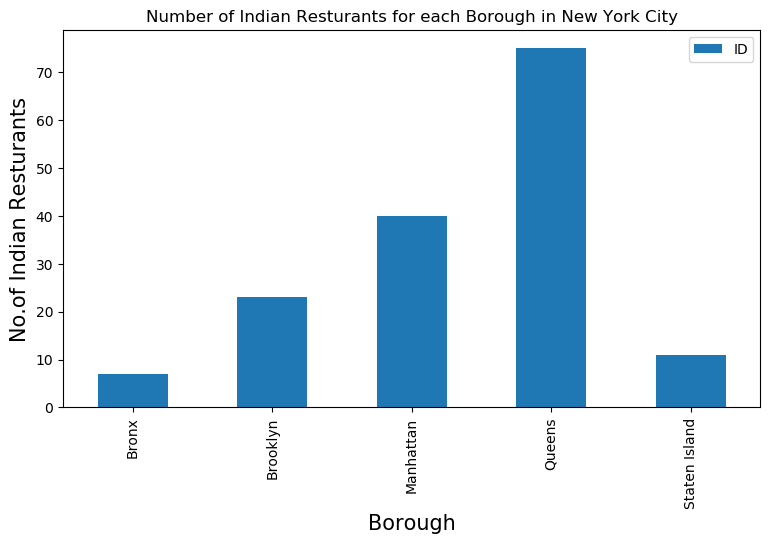

In [15]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

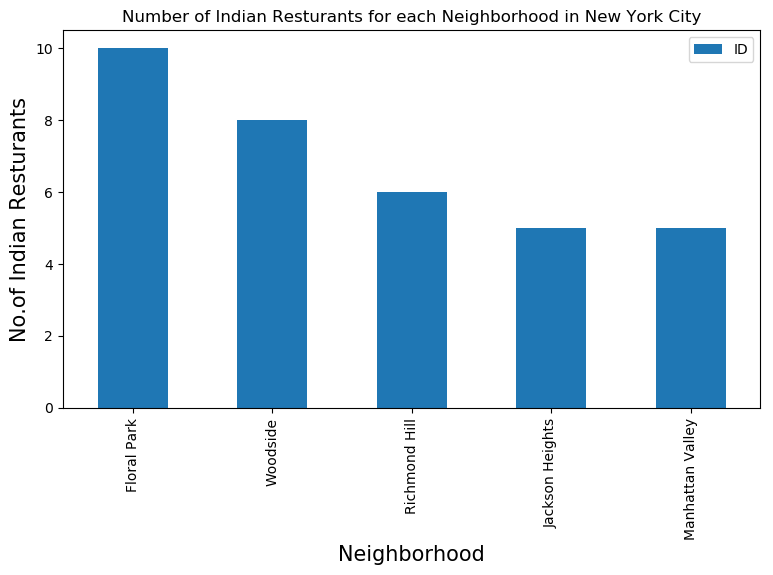

In [16]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [17]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']


,Borough,Neighborhood,ID,Name
101,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
102,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
103,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
104,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
105,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
106,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
107,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
108,Queens,Floral Park,4cc642ed306e224b5bf2a76c,Shahi Darbar
109,Queens,Floral Park,4ec1b54f4690d2338a359d66,Tabaq Kebab Grill
110,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


So Floral Park in Queens has the highest number of Indian Restaurants with a total count of 11.

Now we will get the ranking of each resturant for further analysis.

In [18]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     8.0    10
( 1 / 156 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 570c3a3fcd10eecd0d0434cd
( 2 / 156 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.3     2
( 3 / 156 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     5.9     9
( 4 / 156 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     6.7     3
( 5 / 156 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.3     2
( 6 / 156 ) processed
                         ID       Name  Likes  Rat

KeyError: 'venue'

In [19]:
indian_rest_stats_ny.head()


,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,8.0,10
1,Bronx,Williamsbridge,0,0,0,0.0,0
2,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.9,9
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.7,3


In [20]:
indian_rest_stats_ny.shape


(50, 7)

In [21]:
indian_rest_ny.shape


(156, 4)

So we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required



In [22]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)


Lets verify the data from saved csv file



In [23]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')


In [24]:
indian_rest_stats_ny_csv.shape


(50, 7)

In [25]:
indian_rest_stats_ny_csv.head()


,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,8.0,10
1,Bronx,Williamsbridge,0,0,0,0.0,0
2,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.9,9
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.7,3


In [26]:
indian_rest_stats_ny.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null object
Rating          50 non-null float64
Tips            50 non-null object
dtypes: float64(1), object(6)
memory usage: 2.8+ KB


We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis



In [27]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')


In [28]:
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')


In [29]:
indian_rest_stats_ny.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null float64
Rating          50 non-null float64
Tips            50 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.8+ KB


Now the data types looks correct



In [30]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Rating                               9.1
Tips                                 148
Name: 40, dtype: object

In [31]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Rating                               9.1
Tips                                 148
Name: 40, dtype: object

In [32]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4a70a75bf964a52016d81fe3
Name                 Bhatti Indian Grill
Likes                                422
Rating                               8.7
Tips                                 160
Name: 49, dtype: object

In [33]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']


In [34]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)


,Neighborhood,Average Rating
28,Tribeca,9.1
13,Greenwich Village,8.9
32,West Village,8.8
19,Murray Hill,8.8
3,Chelsea,8.7
5,Clinton Hill,8.7
10,Fort Greene,8.7
12,Gramercy,8.7
23,Prospect Lefferts Gardens,8.6
35,Yorkville,8.5


Above are the top neighborhoods with top average rating of Indian resturant



In [35]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [36]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()


,Borough,Average Rating
2,Manhattan,8.134615
1,Brooklyn,7.394444
0,Bronx,5.533333


Similarly these are the average rating of Indian Resturants for each Borough

Lets visualize it

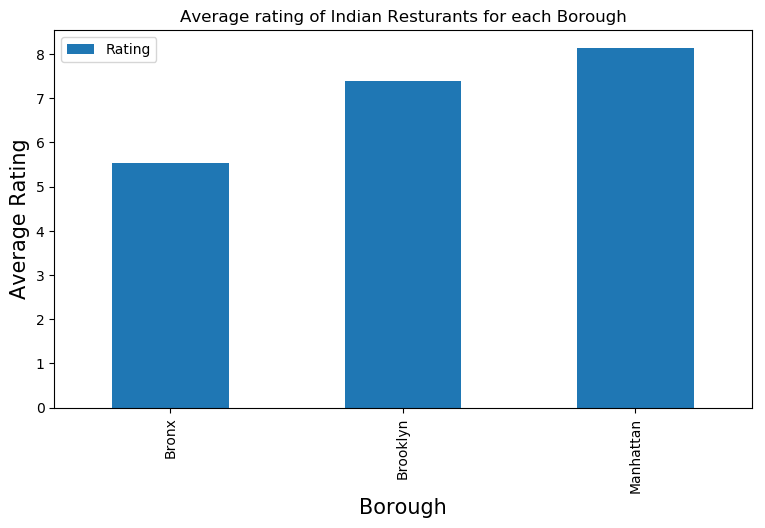

In [59]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map



In [38]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]


In [39]:
ny_neighborhood_stats


,Neighborhood,Average Rating
28,Tribeca,9.1


In [40]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')


In [41]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]


In [43]:
ny_neighborhood_stats


,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Tribeca,40.721522,-74.010683,9.1


In [80]:
folium_map = folium.Map(location=[ny_neighborhood_stats.Latitude, ny_neighborhood_stats.Longitude],tiles='OpenStreetMap',zoom_start=20)

marker = folium.CircleMarker(location=[ny_neighborhood_stats.Latitude, ny_neighborhood_stats.Longitude], tooltip='Tribeca')
marker.add_to(folium_map)
folium_map

# Conclusion

* There are total of 306 different Neighbourhoods in New York
* We have 156 Indian Restaurants across New York City
* Floral Park in Queens has the highest number of Indian Restaurants with a total count of 11
* Tribeca has the highest average rating = 9.1 for Indian restaurants among all neighbourhoods
* Top 3 Boroughs with top average ranking of Indian restaurants are: Manhattan (8.13), Brooklyn (7.39) and Bronx (5.53)
* I would like to choose Tribeca as my preferred location of best-rated Indian Restaurant in New York.


# Limitations

* The ranking is purely on basis of rating of restaurants
* The accuracy of data depends purely depends on the data provided by FourSquare